# U-Net

Reference: https://arxiv.org/pdf/1505.04597.pdf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model

from urllib.request import urlopen
import zipfile
import imageio
import glob

In [0]:
# Download and unzip data
data_url = "https://cloudstor.aarnet.edu.au/plus/s/DGhqTXaciDyiQvb/download"
download_path = 'data.zip'
url = urlopen(data_url)
output = open(download_path, 'wb')        
output.write(url.read())
output.close()

with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall()

In [0]:
def loadData(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "keras_png_slices_data"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        images.append(im)
        
    return np.array(images)

In [0]:
# Load data into np arrays
X_train = loadData("keras_png_slices_train")
y_train = loadData("keras_png_slices_seg_train")
X_test = loadData("keras_png_slices_test")
y_test = loadData("keras_png_slices_seg_test")
X_validation = loadData("keras_png_slices_validate")
y_validation = loadData("keras_png_slices_seg_validate")

In [0]:
# Normalise data
X_train = X_train.astype('float32') / 255.0
X_validation = X_validation.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
y_validation = y_validation.astype('float32') / 255.0
y_test = y_test.astype('float32') / 255.0

In [0]:
X_test[122,:,:].dtype

dtype('float32')

In [0]:
# Add one channel to images in order to have 4-D arrays to feed the U-Net
train_samples = X_train.shape[0]
validation_samples = X_validation.shape[0]
test_samples = X_test.shape[0]

h = X_train.shape[1]
w = X_train.shape[2]
channels = 1
# get num of unique channels in seg images
output_channels = np.unique(y_train).shape[0]

X_train = X_train.reshape(X_train.shape[0], h, w, channels)
X_validation = X_validation.reshape(X_validation.shape[0], h, w, channels)
X_test = X_test.reshape(X_test.shape[0], h, w, channels)
y_train = y_train.reshape(y_train.shape[0], h, w, channels)
y_validation = y_validation.reshape(y_validation.shape[0], h, w, channels)
y_test = y_test.reshape(y_test.shape[0], h, w, channels)

In [0]:
X_train.shape

(9664, 256, 256, 1)

In [0]:
X_validation.shape

(1120, 256, 256, 1)

In [0]:
X_test.shape

(544, 256, 256, 1)

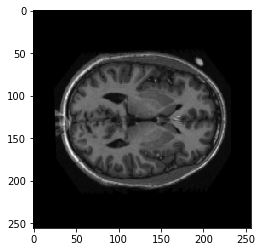

In [0]:
# Visualise one image to check correct load of data
plt.imshow(X_train[122,:,:,0], cmap='gray')

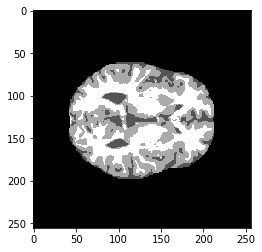

In [0]:
plt.imshow(y_train[122,:,:,0], cmap='gray')

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
# U-Net architecture

# Contracting path
model_in = Input(shape=(h, w, channels))
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(model_in)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
down1 = MaxPooling2D((2, 2), strides=2)(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(down1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
down2 = MaxPooling2D((2, 2), strides=2)(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(down2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
down3 = MaxPooling2D((2, 2), strides=2)(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(down3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
down4 = MaxPooling2D((2, 2), strides=2)(conv4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(down4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

# Expansive path
up1 = UpSampling2D((2, 2))(conv5)
conv6 = Conv2D(512, (2, 2), activation='relu', padding='same')(up1)
concat1 = concatenate([conv4, conv6], axis=3)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up2 = UpSampling2D((2, 2))(conv6)
conv7 = Conv2D(256, (2, 2), activation='relu', padding='same')(up2)
concat2 = concatenate([conv3, conv7], axis=3)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up3 = UpSampling2D((2, 2))(conv7)
conv8 = Conv2D(128, (2, 2), activation='relu', padding='same')(up3)
concat3 = concatenate([conv2, conv8], axis=3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up4 = UpSampling2D((2, 2))(conv8)
conv9 = Conv2D(64, (2, 2), activation='relu', padding='same')(up4)
concat4 = concatenate([conv1, conv9], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(output_channels, (1, 1), activation='softmax', padding='same')(conv9)

model = Model(model_in, conv10)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


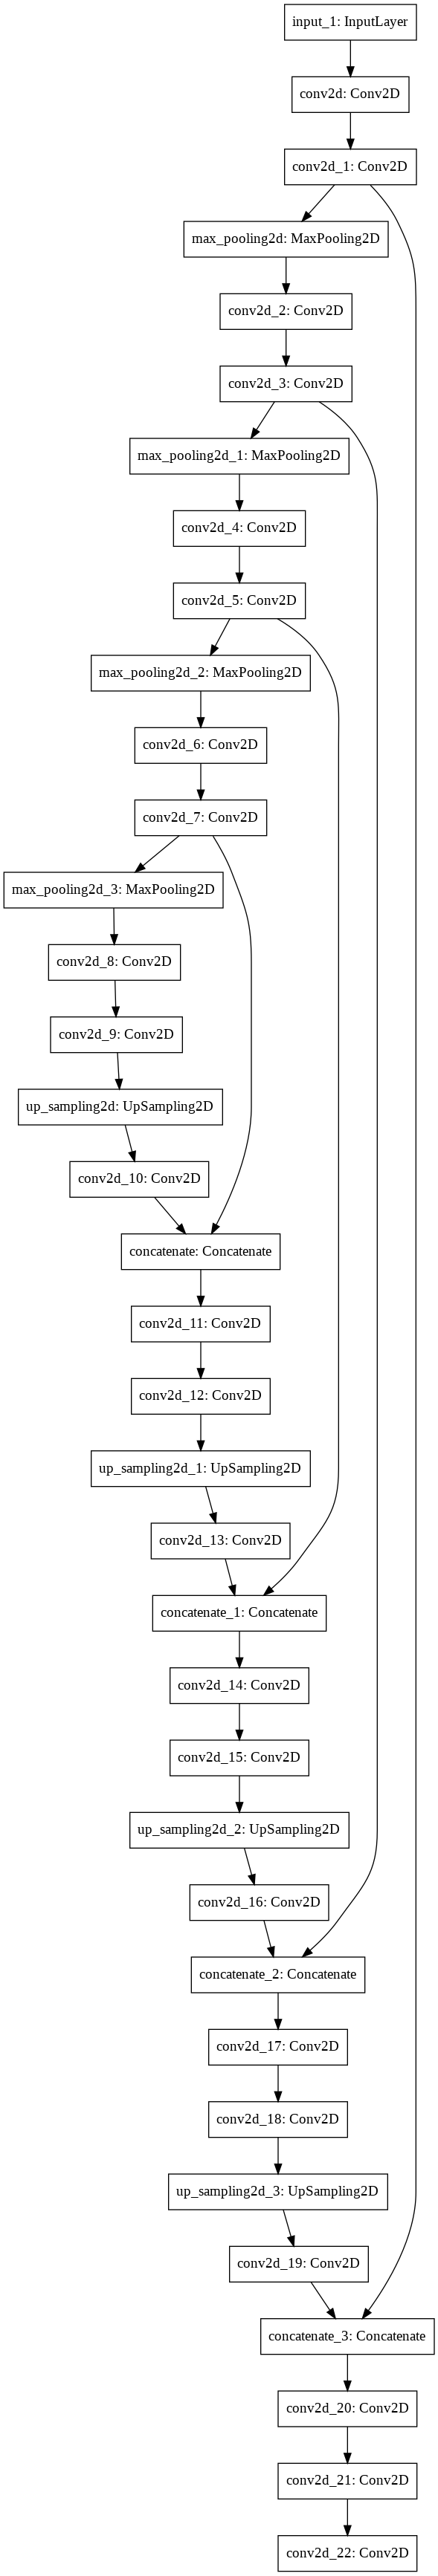

In [0]:
plot_model(model, to_file="model.png")

In [0]:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
9664/9664 [==============================] - 33716s 3s/sample - loss: 1.7175 - acc: 0.7211


In [0]:
model.save('my_model.h5')

In [0]:
loss, accuracy = model.evaluate(X_test, y_test)

544/544 [==============================] - 502s 922ms/sample - loss: 1.7042 - acc: 0.7226
